In [95]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

In [96]:
df = pd.read_csv('diabetes.csv')
df.shape

(768, 9)

In [97]:
X = df.drop(columns = 'Outcome')
y = df['Outcome']

In [98]:
scaler = StandardScaler()
scaler.fit(X)
X_transformed = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.1, stratify = y, random_state=42)

In [99]:
model = svm.SVC(kernel="linear", probability=True)
model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [100]:
acc_score = accuracy_score(model.predict(X_train), y_train)
print(f"Accuracy score for train data is {acc_score}")

Accuracy score for train data is 0.7771345875542692


In [101]:
acc_score = accuracy_score(model.predict(X_test), y_test)
print(f"Accuracy score for test data is {acc_score}")

Accuracy score for test data is 0.7402597402597403


In [103]:
# to numpy array
X = X_train
Y = y_train

In [104]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
Y = y
X = X
classifier = model # or regressor

In [105]:
def plot_probability_surface(classifier, levels=20, points=True):
    xx, yy = np.meshgrid(np.linspace(5, 30, 500), np.linspace(5, 45, 500))
    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    fig, axis = plt.subplots(1, 1, figsize=(10, 10))
    axis.contourf(xx, yy, Z, alpha=0.75, cmap='bone', vmin=0, vmax=1, levels=levels)
    if points:
        axis.scatter(X[:, 0], X[:, 1], c=Y, s=15,
                    cmap='bone', edgecolors='black', linewidth=.5)
    axis.axis('off')
    return axis
# ax = plot_probability_surface(classifier) # cant plot for 8 features atm

In [106]:
import scipy.stats 
def cost_function(x_prime, x, y_prime, lambda_value, model, X):
    mad =  scipy.stats.median_abs_deviation(X, axis=0)
    distance = np.sum(np.abs(x-x_prime)/mad)
    misfit = (model(x_prime, y_prime)-y_prime)**2
    return lambda_value * misfit + distance

In [107]:
def evaluate_model(x, y_prime):
    # round the y_prime value to provide the right class [0,1]
    # predicted_prob = classifier.predict_proba(x.reshape((1, -1)))[0,int(np.round(y_prime))]
    predicted_prob = classifier.predict_proba(x.reshape((1, -1)))[0][0]
    print(predicted_prob)
    return predicted_prob

In [108]:
def get_counterfactuals(x, y_prime_target, model):
    eps = .05 # tolerance
    lambda_min =  1e-10
    lambda_max = 1e5
    lambda_steps = 30
    lambdas = np.logspace(np.log10(lambda_min), 
                            np.log10(lambda_max), 
                            lambda_steps)
    # scan over lambda
    candidates = []
    Y_primes = []
    for lambda_k in lambdas:
        arguments = x, y_prime_target, lambda_k, model, X
        # optimise the cost function -- assuming here it's smooth
        solution = scipy.optimize.minimize(cost_function, 
                                           x, # start from our current observation
                                           args=arguments)
        x_prime_hat = solution.x
        Y_primes.append(model(x_prime_hat, y_prime_target))
        candidates.append(x_prime_hat)
    Y_primes = np.array(Y_primes)
    candidates = np.array(candidates)
    # check if any counterfactual candidates meet the tolerance condition
    eps_condition = np.abs(Y_primes - y_prime_target) <= eps
    # plot y_primes over lambda
    #print(Y_primes)
    #plt.plot(lambdas, Y_primes)
    #plt.show()
    return candidates[eps_condition]

In [109]:
instance = 1
print(f'instance {instance} has features {X[instance]} and label {Y[instance]}')
print('model prediction: ', classifier.predict(X[instance].reshape(1, -1)))
print('model probability: ', classifier.predict_proba(X[instance].reshape(1, -1)))

instance 1 has features [-0.84488505 -1.02950492 -2.02166474  1.34636635  0.16671612  2.92008462
  0.07285643 -0.61611067] and label 0
model prediction:  [0]
model probability:  [[0.51898184 0.48101816]]


0.5189818447934756
0.5189818434676795
0.5189818407700563
0.5189818456037936
0.5189818452246954
0.5189818448366136
0.5189818423756869
0.5189818438593412
0.5189818445312597
0.6612769601016202
0.6612769589816
0.661276956702803
0.661276960786106
0.6612769604658578
0.6612769601380147
0.6612769580591833
0.6612769593125118
0.661276959880075
0.5400597188016936
0.5400597174846106
0.5400597148047939
0.5400597196066734
0.5400597192300703
0.5400597188445466
0.5400597163998362
0.540059717873716
0.5400597185411958
0.521932253886991
0.5219322525619626
0.5219322498659587
0.5219322546968164
0.5219322543179432
0.5219322539300797
0.5219322514706246
0.5219322529533977
0.5219322536249319
0.5193938851172518
0.5193938837915583
0.5193938810941597
0.5193938859275217
0.5193938855484387
0.5193938851603711
0.5193938826996611
0.5193938841831864
0.5193938848550579
0.5190393759215404
0.5190393745957235
0.5190393718981519
0.5190393767318311
0.5190393763527543
0.5190393759646627
0.5190393735037715
0.5190393749873884
0

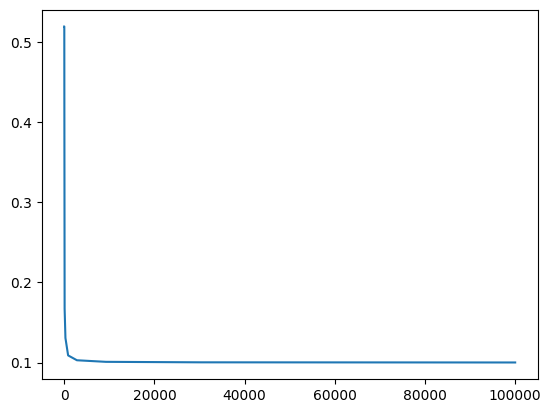

array([[-0.84488506,  0.79076015, -2.02616434,  1.34627739,  0.16490123,
         2.92004952,  0.07509636, -0.62445788],
       [-0.84488505,  0.98219688, -2.02166475,  1.34636633,  0.16671613,
         2.92008462,  0.07285644, -0.61611067],
       [-0.84488506,  1.04131107, -2.02166475,  1.34636635,  0.16671612,
         2.92008462,  0.07285643, -0.61611068],
       [-0.84488506,  1.06117468, -2.02166475,  1.34636635,  0.16671612,
         2.92008463,  0.07285643, -0.61611068],
       [-0.84488495,  1.06741795, -2.02166469,  1.34636583,  0.16671686,
         2.92008462,  0.07285654, -0.61611053],
       [-0.84488506,  1.06933744, -2.02166475,  1.34636635,  0.16671612,
         2.92008462,  0.07285642, -0.61611067]])

In [110]:
P_prime = 0.1
counterfactuals = get_counterfactuals(X[instance], P_prime, evaluate_model)
counterfactuals

In [111]:
best_counterfactual = counterfactuals[-1]
print("best counterfactual:", best_counterfactual)
print("model prediction on counterfactual:", classifier.predict(best_counterfactual.reshape(1, -1)))
print("Model prediction probs on counterfactual:", classifier.predict_proba(best_counterfactual.reshape(1, -1)))
print("% difference (x', x):", (100*(best_counterfactual-X[instance])/X[instance]).round(2))

best counterfactual: [-0.84488506  1.06933744 -2.02166475  1.34636635  0.16671612  2.92008462
  0.07285642 -0.61611067]
model prediction on counterfactual: [1]
Model prediction probs on counterfactual: [[0.10008193 0.89991807]]
% difference (x', x): [   0.   -203.87    0.     -0.     -0.     -0.     -0.      0.  ]
